<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/Cross_Correaltion_Hailisu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Importing packages


In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
data preparation
We generate the first 3 main principal components that capture the most useful information of the data. P1, P2 and P3 are not correalted with each other while they are epressed as the linear cominination of the available featurdes, i.e. ET0, VPD, Rn and T (air temperature)

**Note:** Make sure that the data file is addressed correctly and it's already avaialble in your Google drive.

In [2]:

# dataFile = 'Changde.xlsx'  
dataFile = 'Hailisu.xlsx'  
# dataFile = 'Lancang.xlsx'  
# dataFile = 'Miyun.xlsx'  
# dataFile = 'Nanmulin.xlsx'  
# dataFile = 'Qiemo.xlsx'

data = pd.read_excel('/content/drive/My Drive/'+ dataFile)

In [3]:
# revising the column names
for col in data.columns:
  newcol = col.split("(")[0].strip()
  data.rename(columns={col:newcol}, inplace=True)

# setting up the index of the data frame
data.set_index("TIMESTAMP", inplace=True)

# resample data daily, forward linear interpolation to fill the missing values
data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

## Optional:
## Generating the first three principal (P1, P2, P3) components basesd on ET0, VPD, Rn and T.
myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(myData)
pca_data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
data["P1"] = pca_data[:,0]
data["P2"] = pca_data[:,1]
data["P3"] = pca_data[:,3]

# displaying the first couple rows of the data table
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3
TIMESTAMP,,,,,,,,,,,,,,,
1990-01-01,1,4.5,-15.9,1.4,74.0,-20.3,-10.8,2.194157,0.049189,0.014773,0.067364,0.353247,-2.604686,0.219401,0.051999
1990-01-02,2,6.3,-14.7,1.2,55.0,-21.6,-7.2,2.455747,0.098182,0.016148,0.067364,0.708336,-2.433856,0.237608,0.013234
1990-01-03,3,6.5,-10.5,1.8,63.0,-15.0,-5.6,2.851274,0.105714,0.021875,0.067364,0.773378,-2.218240,0.177261,0.023540
1990-01-04,4,6.8,-14.6,1.4,71.0,-18.5,-8.6,2.698292,0.057183,0.016267,0.067364,0.455943,-2.477608,0.140149,0.051026
1990-01-05,5,5.8,-15.2,1.1,55.0,-22.2,-5.9,2.000768,0.090000,0.015562,0.067364,0.627822,-2.522159,0.310003,0.011304


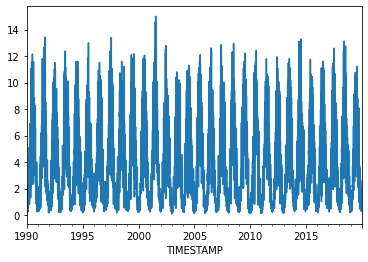

In [4]:
data["ET0"].plot()

# Data Exploration

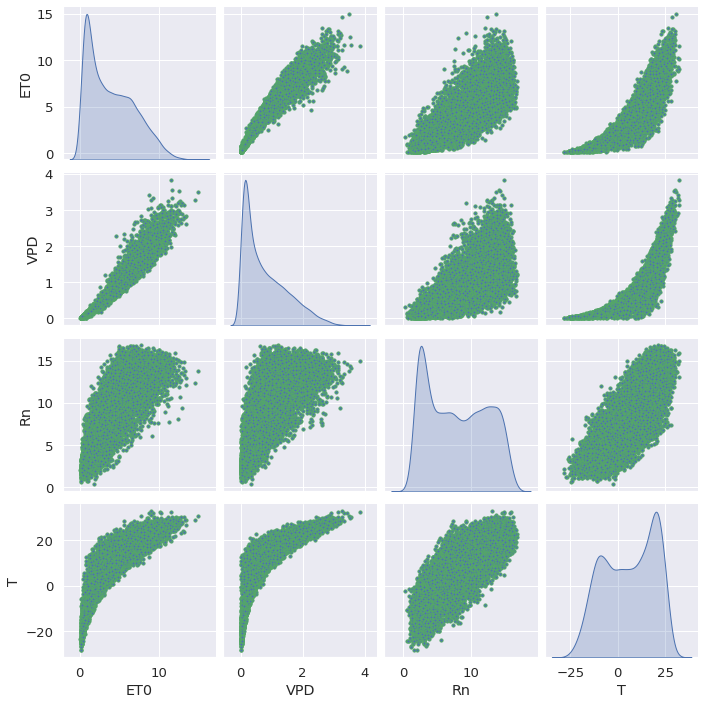

In [5]:
import seaborn as sns
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.2)
pp = sns.pairplot(data[["ET0", "VPD", "Rn", "T"]].dropna(), diag_kind="kde", markers=".", plot_kws=dict(s=40, edgecolor="g", linewidth=1),diag_kws=dict(shade=True))

# Looking at features mutual correlations

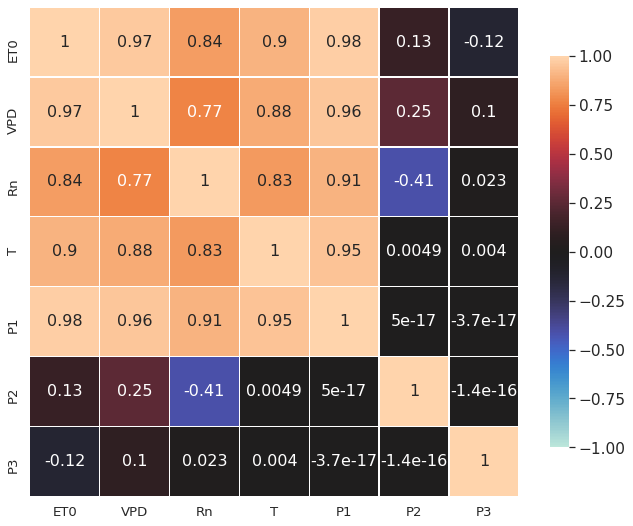

In [6]:
corr = data[["ET0", "VPD", "Rn", "T", "P1", "P2", "P3"]].dropna().corr()

### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.4)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 16}, annot=True) # , mask=mask)

# Staging some data for ML modeling


Generating train and test data sets.
For the sake of speed, we use use a fraction of data for evaluation of our algorithm. Later to get the final results, we use the entire data set.

Text(0.5, 0, 'Time')

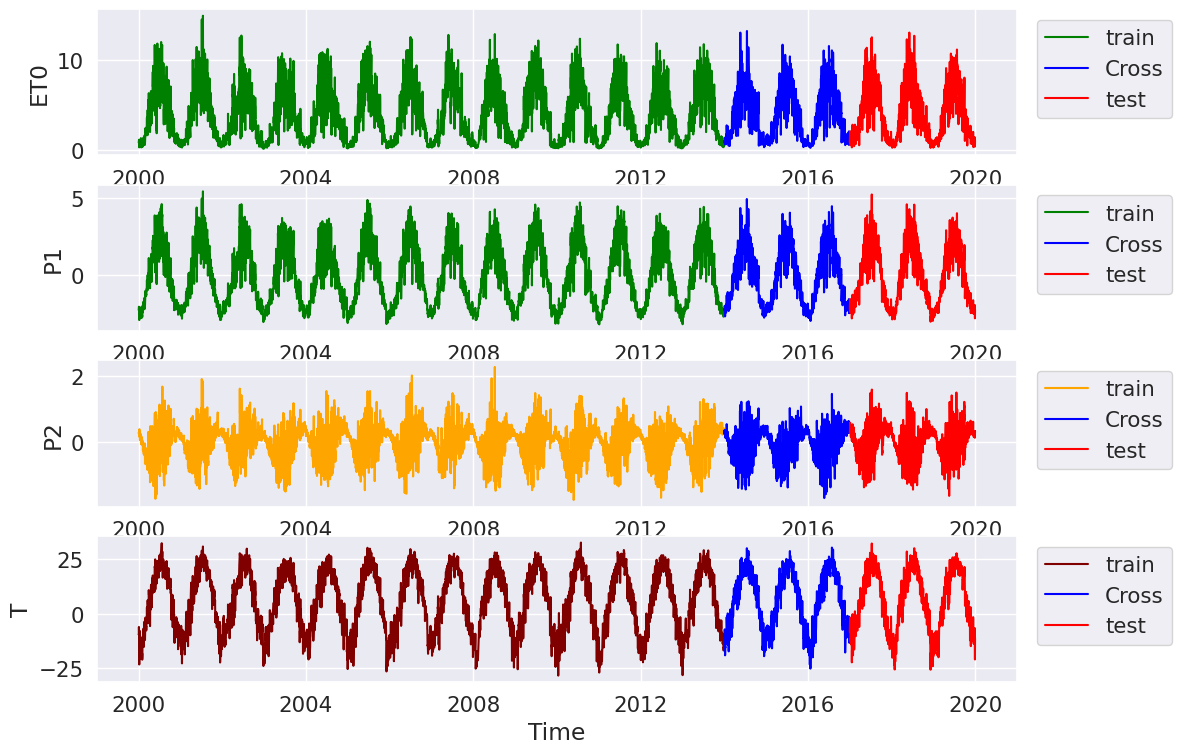

In [7]:
fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

# training: 2010-2017
subData = data.loc["2000":"2013-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"].ffill()
z = subData["P1"].ffill()
v = subData["P2"].ffill()
w = subData["T"].ffill()


# cross validation: 2013 onward
subData_cross = data.loc["2014":"2016-12-31"]
N_cross = len(subData_cross)
x_cross = subData_cross.index
y_cross = subData_cross["ET0"].ffill()
z_cross = subData_cross["P1"].ffill()
v_cross = subData_cross["P2"].ffill()
w_cross = subData_cross["T"].ffill()


# testing: 2013 onward
subData_test = data.loc["2017":]
N_test = len(subData_test)
x_test = subData_test.index
y_test = subData_test["ET0"].ffill()
z_test = subData_test["P1"].ffill()
v_test = subData_test["P2"].ffill()
w_test = subData_test["T"].ffill()

# top plot 
p = 0

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, y, color='green', label="train")
ax.plot(x_cross, y_cross, color='blue', label="Cross")
ax.plot(x_test, y_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("ET0")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, z, color='green', label="train")
ax.plot(x_cross, z_cross, color='blue', label="Cross")
ax.plot(x_test, z_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("P1")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, v, color='orange', label="train")
ax.plot(x_cross, v_cross, color='blue', label="Cross")
ax.plot(x_test, v_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("P2")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, w, color='maroon', label="train")
ax.plot(x_cross, w_cross, color='blue', label="Cross")
ax.plot(x_test, w_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("T")


ax.set_xlabel("Time")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


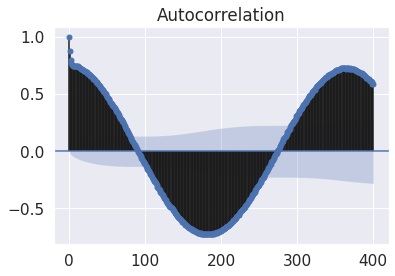

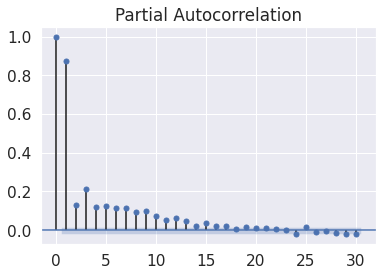

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = data["ET0"].ffill().bfill()

plot_acf(y, lags=400)
plt.show()

plot_pacf(y, lags=30)
plt.show()

In [34]:
data.columns

Index(['DOY', 'U', 'T', 'ea（hpa）', 'RH', 'TA_min', 'TA_max', 'Rn', 'VPD',
       'Delta', 'gamma', 'ET0', 'P1', 'P2', 'P3'],
      dtype='object')

Text(0.5, 0, 'Lag (day)')

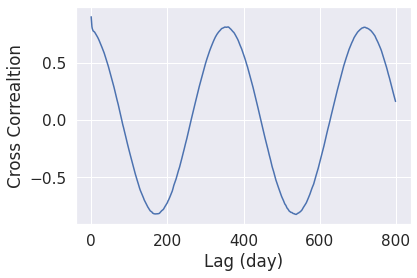

In [43]:
import statsmodels.tsa.stattools as stattools

plt.plot(stattools.ccf(data["ET0"], data["T"])[:800])
plt.ylabel("Cross Correaltion")
plt.xlabel("Lag (day)")

In [39]:
pip install pingouin

     |████████████████████████████████| 225kB 7.9MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-cp36-none-any.whl size=221688 sha256=e2cdc0d6ca9bcf86d63a4ed81588e4b7892332e17f22e55fbc9f075f95fb9002
  Stored in directory: /root/.cache/pip/wheels/d6/9e/53/f885f73f29cf7c8cac3d8f4b1532bbfef2f5eb543946ac9055
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4961 sha256=f2d929ebb1ebed510b22da8a4dc83e1d5e27a771551c745e30db68fa649af4b5
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7051 sha256=8e20d795dedf317d00bd966920fdf616c8342080f7a84959fdc9d20e79974625
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


In [93]:
from pingouin import *

import warnings
warnings.filterwarnings("ignore")

In [141]:
def pccf_(dataFrame, xx, yy, lag=1):

  df = dataFrame[[xx, yy]]
  cols = []

  for i in range(lag):
    col = 'z'+str(i)
    cols.append(col)
    df[col] = df[yy].shift(i+1, 'D')

  df = df.iloc[lag:]
  corr = partial_corr(data=df, x=xx, y=cols[lag-1], covar=cols[:-1], method='pearson')

  C = corr['r'].pearson
  CI95 = corr["CI95%"].pearson

  return C, CI95[0], CI95[1]

#################################################

def pccf(dataFrame, xx, yy, lag=1):
  PCC = [] 
  CI1 = []
  CI2 = []
  for l in range(1,lag):
    PCC_, CI1_, CI2_ = pccf_(dataFrame, xx, yy, lag=l)
    PCC.append(PCC_)
    CI1.append(CI1_)
    CI2.append(CI2_)
  return PCC, CI1, CI2

Text(0.5, 1.0, 'Hailisu (ET0 & P1)')

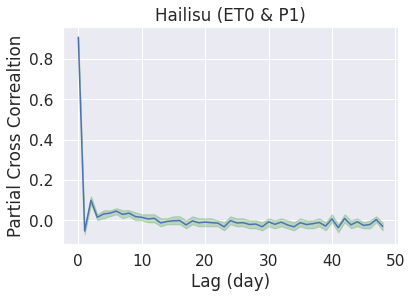

In [165]:
data["TA_max-TA_min"] = data["TA_max"] - data["TA_min"]

xx = 'ET0'
yy = 'P1'

PCC, CI1, CI2 = pccf(data, xx, yy, lag=50)

N = len(PCC)

plt.plot(PCC)
plt.fill_between(range(N), CI1, CI2, color='green', alpha=0.2)

plt.ylabel("Partial Cross Correaltion")
plt.xlabel("Lag (day)")
plt.title("Hailisu ("+ xx + " & " + yy + ")")

In [127]:
corr = partial_corr(data=data, x='ET0', y='T', covar=[], method='pearson')

corr

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,10957,0.901412,"[0.9, 0.9]",0.812544,0.812509,0.0,inf,1.0


In [130]:
data

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3,ET1
TIMESTAMP,,,,,,,,,,,,,,,,
1990-01-01,1,4.5,-15.9,1.4,74.0,-20.3,-10.8,2.194157,0.049189,0.014773,0.067364,0.353247,-2.604686,0.219401,0.051999,0.353247
1990-01-02,2,6.3,-14.7,1.2,55.0,-21.6,-7.2,2.455747,0.098182,0.016148,0.067364,0.708336,-2.433856,0.237608,0.013234,0.708336
1990-01-03,3,6.5,-10.5,1.8,63.0,-15.0,-5.6,2.851274,0.105714,0.021875,0.067364,0.773378,-2.218240,0.177261,0.023540,0.773378
1990-01-04,4,6.8,-14.6,1.4,71.0,-18.5,-8.6,2.698292,0.057183,0.016267,0.067364,0.455943,-2.477608,0.140149,0.051026,0.455943
1990-01-05,5,5.8,-15.2,1.1,55.0,-22.2,-5.9,2.000768,0.090000,0.015562,0.067364,0.627822,-2.522159,0.310003,0.011304,0.627822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,361,9.1,-8.9,1.9,60.5,-12.3,-5.3,2.355786,0.124050,0.024480,0.067364,0.941397,-2.170319,0.299880,-0.017406,0.941397
2019-12-28,362,7.0,-6.6,1.7,45.5,-11.5,-2.5,2.653490,0.203626,0.028695,0.067364,1.386416,-1.917007,0.342008,-0.049323,1.386416
2019-12-29,363,6.0,-17.8,1.1,66.3,-21.7,-5.8,2.655084,0.055913,0.012805,0.067364,0.430025,-2.606307,0.142769,0.049372,0.430025
